In [1]:
import numpy as np
import pandas as pd
import time
import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from boris_util import *

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# Exploring the Dataset

First thing's first, let's load the dataset. I created a new function that loads up the dataset for me and converts it into a pandas dataframe for easy access. For more information on this, please see the `Data Cleaning` notebook

In [3]:
dataset = read_and_combine_data('453_923_bundle_archive', read_noisy_data=False)
print(dataset.shape)
dataset.head()

processed 100.00%
(436, 4)


,signal,sampling_rate,audio_length,label
0,"[2.2960085e-05, -0.00012982322, -0.00018070513...",22050,9.0,artifact
1,"[-1.0927635e-05, 1.0574424e-06, 2.108567e-06, ...",22050,9.0,artifact
2,"[3.728857e-05, -0.0001664555, -7.4023155e-05, ...",22050,9.0,artifact
3,"[-0.0027429417, -0.0066496185, -0.0049779303, ...",22050,9.0,artifact
4,"[0.000106223946, 0.0015002153, 0.0097254915, 0...",22050,9.0,artifact


Let's take a look at the class distribution to see if there is any concern of class imbalance

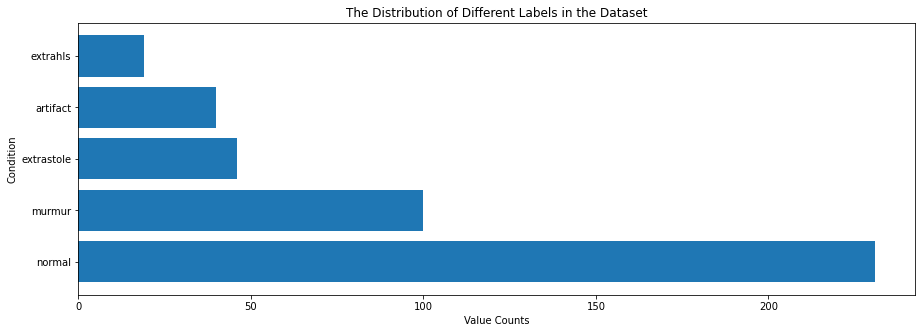

In [4]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Dataset")
plt.show()

There is certainly an issue of class imbalance here. A naive classifier could guess pretty well by simply guessing "Normal" on all the examples

## Combine all Abnormalities

Let's try and simplify the problem first, we will combine all abnormalities into a single label "abnormal".

In [5]:
def relabel(label):
    if (label == "normal"):
        return "normal"
    else:
        return "abnormal"
dataset['label'] = dataset['label'].apply(relabel)

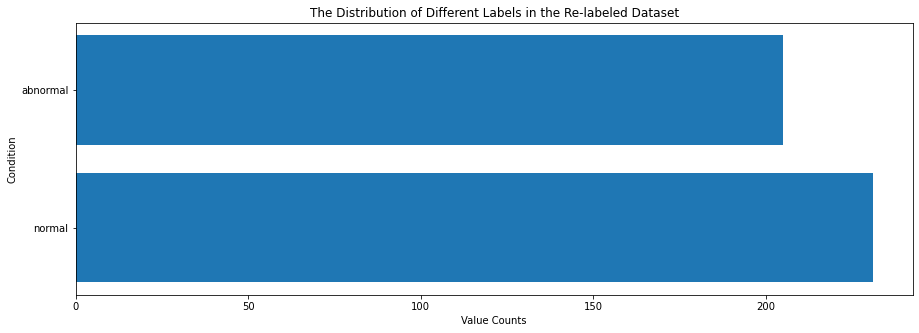

In [6]:
label_counts = dataset['label'].value_counts()

plt.figure(figsize=(15,5))
plt.barh(label_counts.index, label_counts.values)
plt.xlabel("Value Counts")
plt.ylabel("Condition")
plt.title("The Distribution of Different Labels in the Re-labeled Dataset")
plt.show()

Let's split our data now into a simple train/test stratified split

In [7]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, stratify=dataset['label'], random_state=1)
print(train_dataset.shape)
print(test_dataset.shape)

(305, 4)
(131, 4)


In [8]:
train_dataset.head()

,signal,sampling_rate,audio_length,label
302,"[-0.014594975, -0.016623363, -0.017930867, -0....",22050,5.025533,normal
401,"[0.00535502, 0.0048318487, 0.0038144102, 0.002...",22050,1.724263,normal
311,"[-0.0009814408, -0.00052338943, 9.0988244e-05,...",22050,3.822766,normal
346,"[-0.007578952, -0.011004641, -0.015165693, -0....",22050,4.312018,normal
410,"[-0.030912954, -0.033952978, -0.035377894, -0....",22050,3.167755,normal


Now let's define a class which will convert the signals into Mel spectrograms

In [9]:
class MelEncoder:
    
    '''
        This transformer takes an audio signal and employes librosa
        to transform the audio signal into a Mel-frequency spectrogram.
        
        The transformation transforms the audio signal from samples in a 
        time domain, to frequencies over each time window. The frequencies
        are then collected into buckets which are easily distinguished by
        human hearing
    '''
    
    def __init__(self, flatten=True, n_fft=2048, hop_length=512, n_mels=128, sampling_rate=22050.0, n_windows=1000, verbose=0):
        
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sampling_rate = sampling_rate
        self.n_windows = n_windows
        self.verbose = verbose
        
        
        self.flatten = flatten
        
    ################################################################################################
    def fit(self, X, y=None):
        '''
            This method doesn't do much except initialize a private variables
        '''
        self.longest_signal_length = None
        
        
    ################################################################################################
    # https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    def _signal_to_mel_spectrogram(self, signal):
        '''
            This method accepts an audio signal as a list of measurements
            and returns the signal broken up into the Mel scale.
            
            If n_windows was specified, the signal is broken up into
            n_windows. Otherwise, the signal is broken up based
            on hop_length and is broken into however many windows
            can be fitted using hop_length
        '''
        
        
        if (self.n_windows is not None):
            hop_length = signal.shape[0]//self.n_windows
        else:
            hop_length = self.hop_length
        S = librosa.feature.melspectrogram(signal, 
                                           sr=self.sampling_rate, 
                                           n_fft=self.n_fft, 
                                           hop_length=hop_length, 
                                           n_mels=self.n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB
    
    ################################################################################################
    def _create_spectrogram_list(self, X):
        '''
            This method accepts a an array of signals 
            (each signal is a list of measurements)
            and returns a list of the Mel spectrograms
            corresponding to each signal
        '''
        
        spectrogram_list = []
        
        
        for i, signal in enumerate(X):
                mel_spectrogram = self._signal_to_mel_spectrogram(signal)
                spectrogram_list.append(mel_spectrogram)
                if (self.verbose):
                    print(f"processed: {round(100*i/X.shape[0], 2)}%", end="\r")
                    
                
        print(f"processed: {round(100*i/X.shape[0], 2)}%")
        
        return spectrogram_list
    
    ################################################################################################
    def _find_longest_signal_length(self, spectrogram_list):
        '''
            This method accepts a spectrogram list and finds
            the length of the longest spectrogram
        '''
        
        max_length = 0
        for mel_spectrogram in spectrogram_list:
            if (mel_spectrogram.shape[1] > max_length):
                max_length = mel_spectrogram.shape[1]

        return max_length
    
    ################################################################################################
    def _build_mel_spectrogram_stack(self, spectrogram_list):
        '''
            This method accepts a list of spectrograms and
            returns a numpy array which is a stack of those
            spectrograms of shape (len(spectrogram_list), n_mels, N)
            where N is the length of the longest spectrogram
            in the list. 
            Empty spots are filled with -80 
            (the default value for no signal)
        '''
        
        X_transformed = np.full(shape=(len(spectrogram_list), self.n_mels, self.longest_signal_length),
                                fill_value=-80.0)
        
        for i, mel_spectrogram in enumerate(spectrogram_list):
            if (mel_spectrogram.shape[1] <= self.longest_signal_length):
                X_transformed[i, :, -mel_spectrogram.shape[1]:] = mel_spectrogram[:, :]
            else:
                X_transformed[i, :, :] = mel_spectrogram[:, -self.longest_signal_length:]
                
        return X_transformed
    
        
    ################################################################################################  
    
    #def _longest_signal(self, signals):
    #    max_length = 0
    #    for signal in signals:
    #        if (len(signal) > max_length):
    #            max_length = len(signal)
    #
    #    return max_length
    
    
    
    
    ################################################################################################
    def transform(self, X):
        '''
            This method accepts an array of audio signals and returns
            a numpy array of spectrograms 
            
            The spectrogram array returns with shape (len(X), n_mels, N) 
            where N is the length of the longest spectrogram, if flatten 
            was set to True
            
            The spectrogram array returns with shape (len(X), n_mels X N) 
            where N is the length of the longest spectrogram, if flatten 
            was set to False
            
            
        '''
        
        spectrogram_list = self._create_spectrogram_list(X)
        
        if (self.longest_signal_length is None):
            self.longest_signal_length = self._find_longest_signal_length(spectrogram_list)
            
        X_transformed = self._build_mel_spectrogram_stack(spectrogram_list)
        
        
        if (self.flatten):
            return X_transformed.reshape(X_transformed.shape[0], -1)
        else:
            return X_transformed
        
    ################################################################################################ 
    def fit_transform(self, X, y=None):
        '''
            This method accepts an array of audio signals and returns
            a numpy array of spectrograms 
            
            The spectrogram array returns with shape (len(X), n_mels, N) 
            where N is the length of the longest spectrogram, if flatten 
            was set to True
            
            The spectrogram array returns with shape (len(X), n_mels X N) 
            where N is the length of the longest spectrogram, if flatten 
            was set to False
        '''
        return self.fit(X).transform(X)

Let's employ out encoder and transform the data. Since we'll be using basic machine learning models we will flatten the output

In [10]:
my_encoder = MelEncoder(n_mels=128, n_windows=1000, verbose=1)
my_encoder.fit(train_dataset['signal'])

X_train_mel = my_encoder.transform(train_dataset['signal'])
X_train_mel.shape

processed: 99.67%


(305, 134400)

In [11]:
X_test_mel = my_encoder.transform(test_dataset['signal'])
X_test_mel.shape

processed: 99.24%


(131, 134400)

## PCA

Since there is a very small collection of data points, we can embed them in a much smaller dimensional space without losing any of the variance.

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
%%time 
my_mmscaler = MinMaxScaler()

X_train_mel = my_mmscaler.fit_transform(X_train_mel)
X_test_mel = my_mmscaler.transform(X_test_mel)

CPU times: user 444 ms, sys: 172 ms, total: 616 ms
Wall time: 618 ms


In [14]:
X_train_mel = X_train_mel
X_train_mel.shape

(305, 134400)

In [15]:
%%time 

component_number = min(*X_train_mel.shape)
my_pca = PCA(n_components=component_number, svd_solver='auto')
my_pca.fit(X_train_mel)

CPU times: user 1min 44s, sys: 5.34 s, total: 1min 50s
Wall time: 13.5 s


PCA(n_components=305)

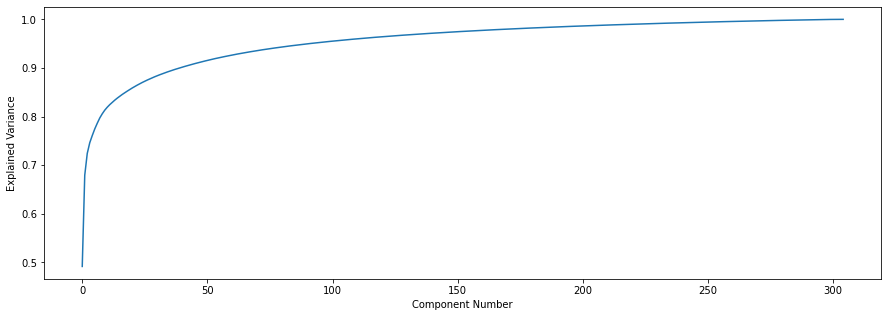

In [16]:
plt.figure(figsize=(15,5))
plt.plot(my_pca.explained_variance_ratio_.cumsum())
plt.xlabel("Component Number")
plt.ylabel("Explained Variance")
plt.show()

In [17]:
X_train_mel = my_pca.transform(X_train_mel)
X_test_mel = my_pca.transform(X_test_mel)

In [18]:
X_train_mel.shape

(305, 305)

In [19]:
X_test_mel.shape

(131, 305)

## Basic Model - Logistic Regression

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

In [20]:
CV_FOLD = 5

In [21]:
condition_label_encoder = LabelEncoder()


y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
y_test = condition_label_encoder.transform(test_dataset['label'])

print(X_train_mel.shape, X_test_mel.shape)
print(y_train.shape, y_test.shape)

(305, 305) (131, 305)
(305,) (131,)


In [22]:
%%time

my_logit = LogisticRegression(random_state=1).fit(X_train_mel, y_train)
train_acc = my_logit.score(X_train_mel, y_train)
test_acc = my_logit.score(X_test_mel, y_test)

CPU times: user 439 ms, sys: 48.1 ms, total: 487 ms
Wall time: 53.3 ms


In [23]:
y_proba_train = my_logit.predict_proba(X_train_mel)[:, 1]
y_proba_test = my_logit.predict_proba(X_test_mel)[:, 1]


train_auc = roc_auc_score(y_train, y_proba_train)
test_auc = roc_auc_score(y_test, y_proba_test)

In [24]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 100.0%
The test accuracy is 56.49%


In [25]:
print(f"The training AUC is {round(train_auc*100,2)}%")
print(f"The test AUC is {round(test_auc*100,2)}%")

The training AUC is 100.0%
The test AUC is 62.74%


In [26]:
y_proba = my_logit.predict_proba(X_test_mel)

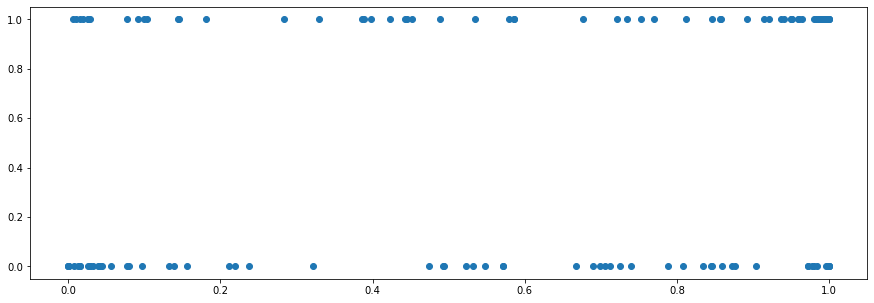

In [27]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

In [28]:
def boris_score(y_true, y_positive_proba):
    
    positive_pure_points = 0
    negative_pure_points = 0
    for threshold in np.unique(y_positive_proba):
        
        under_threshold = y_true[y_positive_proba < threshold]
        if (np.sum(under_threshold) == 0):
            if (len(under_threshold) > negative_pure_points):
                negative_pure_points = len(under_threshold)
                
        over_threshold = y_true[y_positive_proba >= threshold]
        if (np.sum(over_threshold) == len(over_threshold)):
            if (len(over_threshold) > positive_pure_points):
                positive_pure_points = len(over_threshold)
                
    return positive_pure_points + negative_pure_points
        
        

In [29]:
from sklearn.metrics import make_scorer
score = make_scorer(boris_score, needs_proba=True)

In [30]:
score(my_logit, X_test_mel, y_test)

6

Extremely suspicious results. There is clearly a very large sign of overfitting here. Let's explore how the logistic regression makes decisions.

Let's plot the coefficients as if they were an audio mask (which is really what they end up becoming).

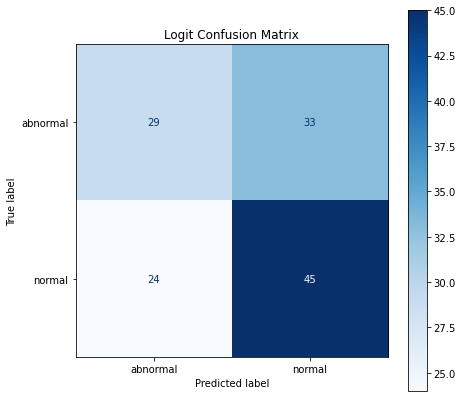

In [31]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

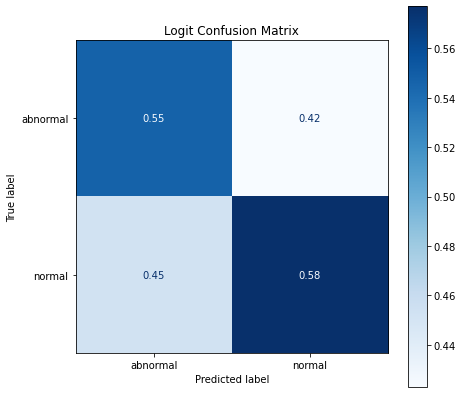

In [32]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [33]:
param_grid = {'penalty': ['l1', 'l2'],
              'C': [2**i for i in range(-17, 18)]}
my_estimator = LogisticRegression(solver='saga')
my_logit_gs = GridSearchCV(my_estimator, param_grid, cv=CV_FOLD, verbose=1, n_jobs=3)

In [34]:
%%time
my_logit_gs.fit(X_train_mel, y_train);

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 166 tasks      | elapsed:    4.4s


CPU times: user 306 ms, sys: 84.2 ms, total: 390 ms
Wall time: 11.1 s


[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:   11.0s finished


GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'), n_jobs=3,
             param_grid={'C': [7.62939453125e-06, 1.52587890625e-05,
                               3.0517578125e-05, 6.103515625e-05,
                               0.0001220703125, 0.000244140625, 0.00048828125,
                               0.0009765625, 0.001953125, 0.00390625, 0.0078125,
                               0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1,
                               2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
                               4096, ...],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [35]:
my_logit_gs.best_params_

{'C': 0.0009765625, 'penalty': 'l2'}

In [36]:
train_acc = my_logit_gs.score(X_train_mel, y_train)
test_acc = my_logit_gs.score(X_test_mel, y_test)

In [37]:
print(f"The training accuracy is {round(train_acc*100,2)}%")
print(f"The test accuracy is {round(test_acc*100,2)}%")

The training accuracy is 81.31%
The test accuracy is 69.47%


In [38]:
y_proba_train = my_logit_gs.predict_proba(X_train_mel)[:, 1]
y_proba_test = my_logit_gs.predict_proba(X_test_mel)[:, 1]


train_auc = roc_auc_score(y_train, y_proba_train)
test_auc = roc_auc_score(y_test, y_proba_test)

In [39]:
print(f"The training AUC is {round(train_auc*100,2)}%")
print(f"The test AUC is {round(test_auc*100,2)}%")

The training AUC is 87.92%
The test AUC is 72.86%


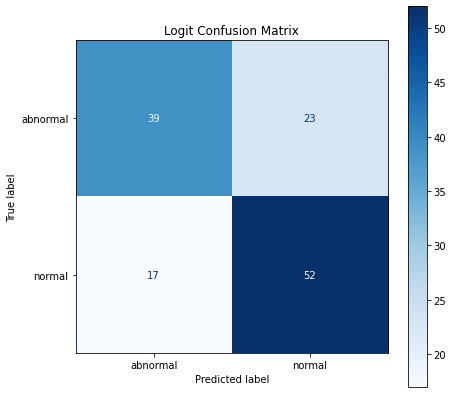

In [40]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit_gs, X_test_mel, y_test,
                             display_labels = condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

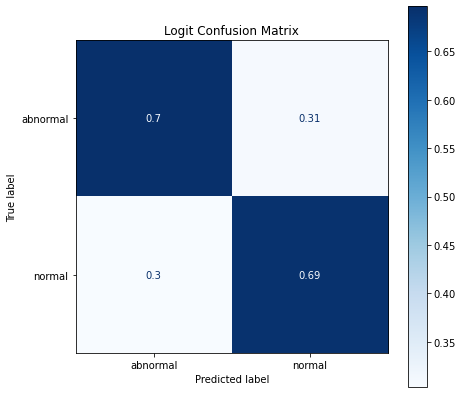

In [41]:
figure, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(my_logit_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
disp.ax_.set_title("Logit Confusion Matrix")
plt.show()

In [42]:
print(classification_report(y_test, my_logit_gs.predict(X_test_mel)))

              precision    recall  f1-score   support

           0       0.70      0.63      0.66        62
           1       0.69      0.75      0.72        69

    accuracy                           0.69       131
   macro avg       0.69      0.69      0.69       131
weighted avg       0.69      0.69      0.69       131



In [43]:
y_proba = my_logit_gs.predict_proba(X_test_mel)

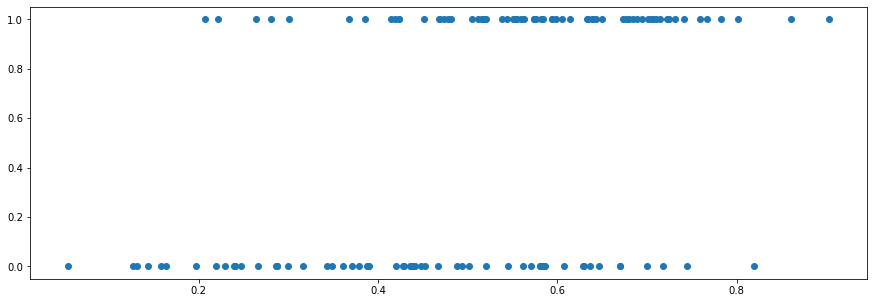

In [44]:
plt.figure(figsize=(15, 5))
plt.scatter(y_proba[:, 1], y_test)
plt.show();

In [45]:
total_run_times_dataframe = pd.DataFrame({"model": [],
                                          "dataset": [],
                                          "score": []})
total_run_times_dataframe

,model,dataset,score


In [46]:
current_row = total_run_times_dataframe.shape[0]
total_run_times_dataframe.loc[current_row, 'model'] = "Logistic Regression"
total_run_times_dataframe.loc[current_row, 'dataset'] = "test"
total_run_times_dataframe.loc[current_row, 'score'] = test_acc

current_row = total_run_times_dataframe.shape[0]
total_run_times_dataframe.loc[current_row, 'model'] = "Logistic Regression"
total_run_times_dataframe.loc[current_row, 'dataset'] = "train"
total_run_times_dataframe.loc[current_row, 'score'] = train_acc
total_run_times_dataframe

,model,dataset,score
0,Logistic Regression,test,0.694656
1,Logistic Regression,train,0.813115


## Let's write a function for all that

In [47]:
def run_model(estimator, param_grid, X_train_mel, y_train, X_test_mel, y_test, total_run_times_dataframe, model_name):
    
    print("Fitting model")
    my_gs = GridSearchCV(estimator, param_grid, cv=CV_FOLD, verbose=1, n_jobs=3)
    my_gs.fit(X_train_mel, y_train);
    
    train_acc = my_gs.score(X_train_mel, y_train)
    test_acc = my_gs.score(X_test_mel, y_test)
    
    print(f"The training accuracy is {round(train_acc*100,2)}%")
    print(f"The test accuracy is {round(test_acc*100,2)}%")
    print(f"Optimal Parameters are: {my_gs.best_params_}")
    
    
    figure, ax = plt.subplots(figsize=(7, 7))
    disp = plot_confusion_matrix(my_gs, X_test_mel, y_test,
                                 display_labels = condition_label_encoder.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                 ax=ax)
    disp.ax_.set_title(f"{model_name} Confusion Matrix")
    plt.show()
    
    figure, ax = plt.subplots(figsize=(7, 7))
    disp = plot_confusion_matrix(my_gs, X_test_mel, y_test,
                             display_labels=condition_label_encoder.classes_,
                             cmap=plt.cm.Blues,
                             normalize='pred',
                             ax=ax)
    disp.ax_.set_title(f"{model_name} Confusion Matrix")
    plt.show()
    
    print(classification_report(y_test, my_gs.predict(X_test_mel)))
    
    y_proba = my_gs.predict_proba(X_test_mel)
    
    plt.figure(figsize=(15, 5))    
    plt.scatter(y_proba[:, 1], y_test)
    plt.xlabel("Probabilities")
    plt.ylabel("True Class")
    plt.title(f"Probabilities Predicted by {model_name} versus the True Classes")
    plt.show();
    
    
    current_row = total_run_times_dataframe.shape[0]
    total_run_times_dataframe.loc[current_row, 'model'] = model_name
    total_run_times_dataframe.loc[current_row, 'dataset'] = "test"
    total_run_times_dataframe.loc[current_row, 'score'] = test_acc

    current_row = total_run_times_dataframe.shape[0]
    total_run_times_dataframe.loc[current_row, 'model'] = model_name
    total_run_times_dataframe.loc[current_row, 'dataset'] = "train"
    total_run_times_dataframe.loc[current_row, 'score'] = train_acc
    total_run_times_dataframe
    
    
    
    
    
    

Fitting model
Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 304 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:    2.1s finished


The training accuracy is 74.75%
The test accuracy is 70.23%


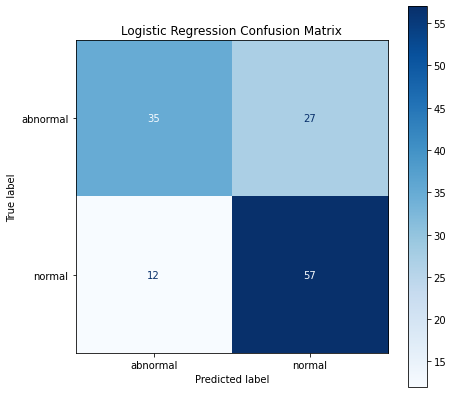

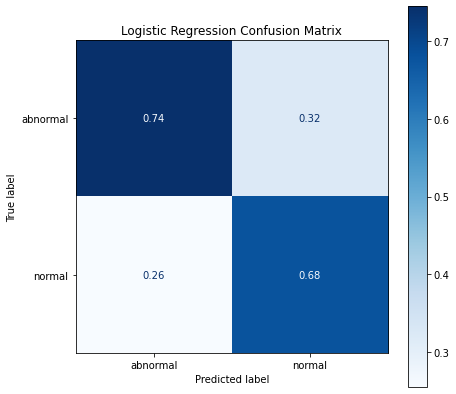

              precision    recall  f1-score   support

           0       0.74      0.56      0.64        62
           1       0.68      0.83      0.75        69

    accuracy                           0.70       131
   macro avg       0.71      0.70      0.69       131
weighted avg       0.71      0.70      0.70       131



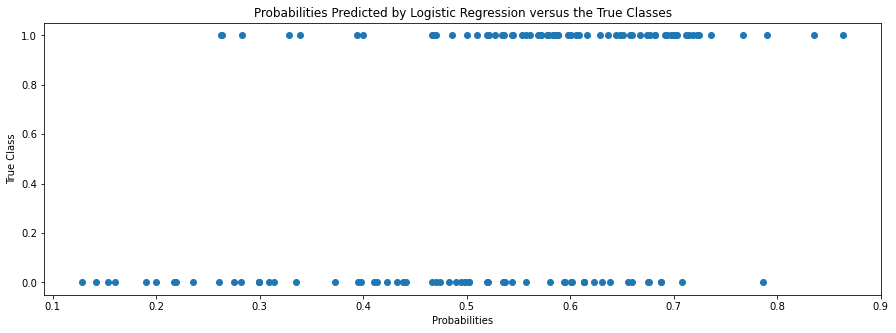

,model,dataset,score
0,Logistic Regression,test,0.702290
1,Logistic Regression,train,0.747541


In [48]:
total_run_times_dataframe = pd.DataFrame({"model": [],
                                          "dataset": [],
                                          "score": []})


run_model(LogisticRegression(random_state=1), 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "Logistic Regression")

total_run_times_dataframe

## Basic Model - Support Vector Machine



Fitting model
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    9.8s finished


The training accuracy is 100.0%
The test accuracy is 68.7%


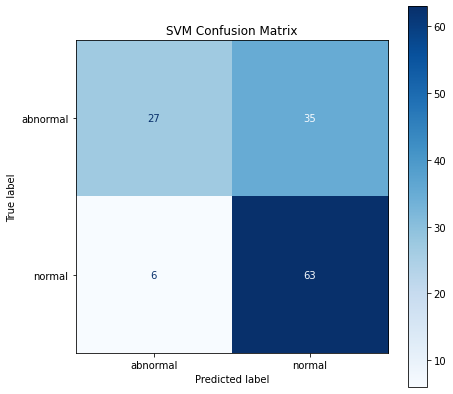

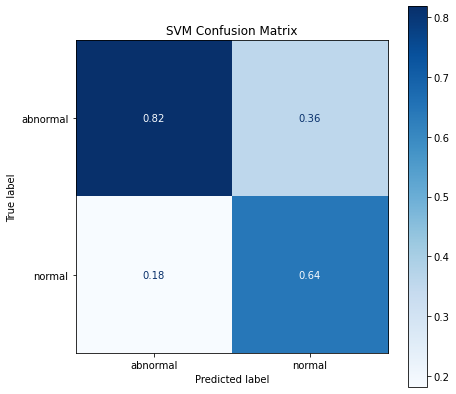

              precision    recall  f1-score   support

           0       0.82      0.44      0.57        62
           1       0.64      0.91      0.75        69

    accuracy                           0.69       131
   macro avg       0.73      0.67      0.66       131
weighted avg       0.73      0.69      0.67       131



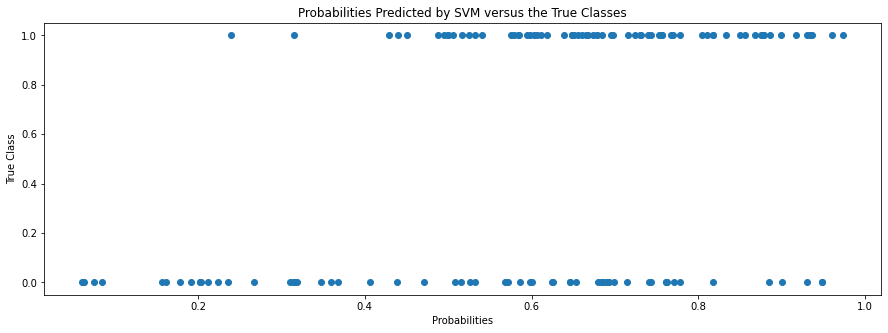

,model,dataset,score
0,Logistic Regression,test,0.702290
1,Logistic Regression,train,0.747541
2,SVM,test,0.687023
3,SVM,train,1.000000


In [49]:
param_grid = {'C': [10**i for i in range(-7, 8)],
              'kernel': ['poly', 'rbf', 'sigmoid', 'linear']}
my_estimator = SVC(max_iter=1000, probability=True, random_state=1)



run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "SVM")

total_run_times_dataframe

## Basic Model - KNN

Let's start by establishing a baseline performance. I am just going to load the raw audio data as features (where each feature is an audio measurement) and see how well a simple logistic regression (linear model) and decision tree (non-linear model) will perform

Fitting model
Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 245 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 280 out of 280 | elapsed:    1.2s finished


The training accuracy is 68.52%
The test accuracy is 66.41%


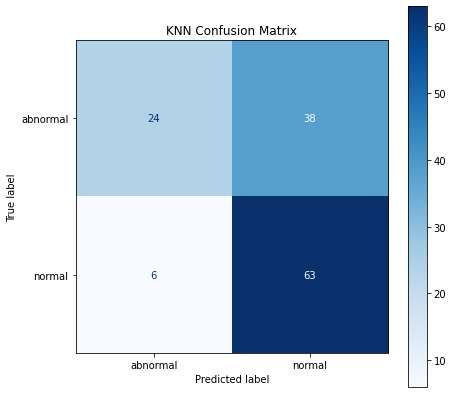

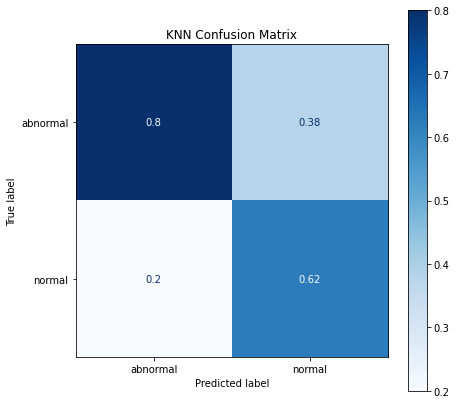

              precision    recall  f1-score   support

           0       0.80      0.39      0.52        62
           1       0.62      0.91      0.74        69

    accuracy                           0.66       131
   macro avg       0.71      0.65      0.63       131
weighted avg       0.71      0.66      0.64       131



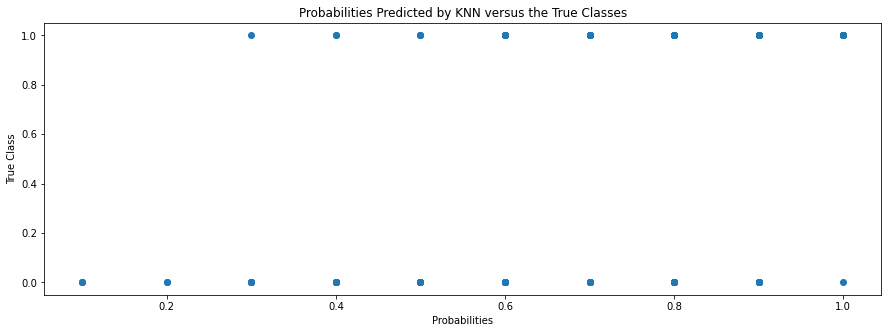

,model,dataset,score
0,Logistic Regression,test,0.702290
1,Logistic Regression,train,0.747541
2,SVM,test,0.687023
3,SVM,train,1.000000
4,KNN,test,0.664122
5,KNN,train,0.685246


In [51]:
param_grid = {'n_neighbors': [i for i in range(3,10)] + \
                             [i for i in range(10, 100, 5)] + \
                             [i for i in range(100, X_train_mel.shape[0]//2, 20)],
              'weights': ['uniform', 'distance']}

my_pipe = Pipeline([('scaler', MinMaxScaler()),
                    ('knn', KNN(algorithm='auto'))])

my_estimator = KNN()



run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "KNN")

total_run_times_dataframe

## Basic Model - Decision Tree

As another baseline, I will train a decision tree to see if introducing non-linearity to the learning process produces better results

Fitting model
Fitting 5 folds for each of 1140 candidates, totalling 5700 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 890 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 5394 tasks      | elapsed:   25.7s


The training accuracy is 79.02%
The test accuracy is 57.25%


[Parallel(n_jobs=3)]: Done 5700 out of 5700 | elapsed:   27.9s finished


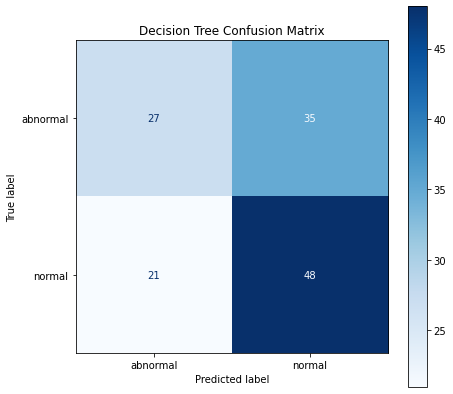

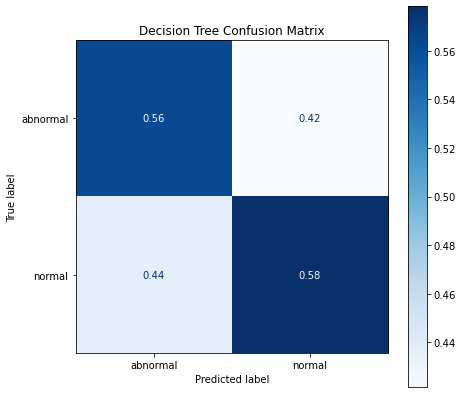

              precision    recall  f1-score   support

           0       0.56      0.44      0.49        62
           1       0.58      0.70      0.63        69

    accuracy                           0.57       131
   macro avg       0.57      0.57      0.56       131
weighted avg       0.57      0.57      0.57       131



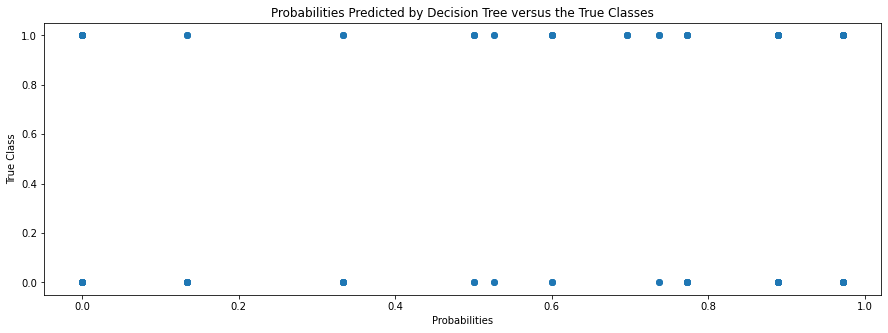

CPU times: user 1.65 s, sys: 90.9 ms, total: 1.74 s
Wall time: 28.4 s


,model,dataset,score
0,Logistic Regression,test,0.702290
1,Logistic Regression,train,0.747541
2,SVM,test,0.687023
3,SVM,train,1.000000
4,KNN,test,0.664122
5,KNN,train,0.685246
6,Decision Tree,test,0.572519
7,Decision Tree,train,0.790164


In [52]:
%%time 

# Let's set some regularization otherwise we know the tree will overfit
my_estimator = DecisionTreeClassifier(random_state=1)
param_grid = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)]}



run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "Decision Tree")

total_run_times_dataframe

## Advanced Model - Random Forest

...

Fitting model
Fitting 5 folds for each of 2280 candidates, totalling 11400 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 146 tasks      | elapsed:    3.0s
[Parallel(n_jobs=3)]: Done 746 tasks      | elapsed:   24.0s
[Parallel(n_jobs=3)]: Done 1359 tasks      | elapsed:   59.3s
[Parallel(n_jobs=3)]: Done 1709 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 2308 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 2958 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 3818 tasks      | elapsed:  5.4min
[Parallel(n_jobs=3)]: Done 4820 tasks      | elapsed:  7.0min
[Parallel(n_jobs=3)]: Done 6024 tasks      | elapsed:  8.9min
[Parallel(n_jobs=3)]: Done 7340 tasks      | elapsed: 11.2min
[Parallel(n_jobs=3)]: Done 8615 tasks      | elapsed: 13.6min
[Parallel(n_jobs=3)]: Done 10260 tasks      | elapsed: 16.2min
[Parallel(n_jobs=3)]: Done 11400 out of 11400 | elapsed: 18.2min finished


The training accuracy is 95.41%
The test accuracy is 67.94%


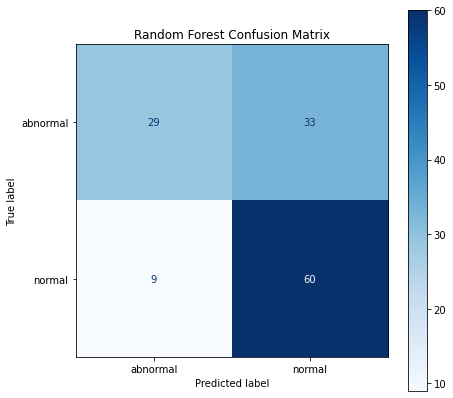

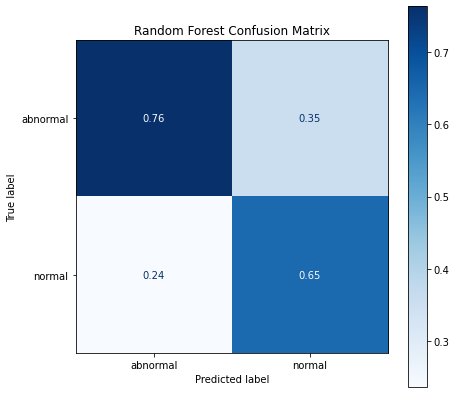

              precision    recall  f1-score   support

           0       0.76      0.47      0.58        62
           1       0.65      0.87      0.74        69

    accuracy                           0.68       131
   macro avg       0.70      0.67      0.66       131
weighted avg       0.70      0.68      0.66       131



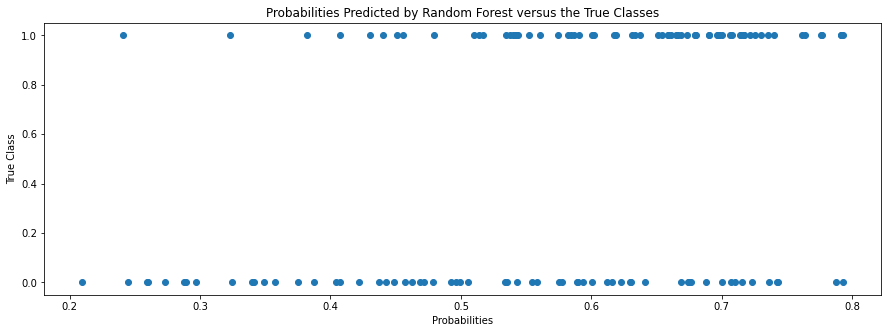

,model,dataset,score
0,Logistic Regression,test,0.702290
1,Logistic Regression,train,0.747541
2,SVM,test,0.687023
3,SVM,train,1.000000
4,KNN,test,0.664122
5,KNN,train,0.685246
6,Decision Tree,test,0.572519
7,Decision Tree,train,0.790164
8,Random Forest,test,0.679389
9,Random Forest,train,0.954098


In [53]:
param_grid = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)],
              'n_estimators': [i*10 for i in range(1,10, 5)]}
my_estimator = RandomForestClassifier(random_state=1)

run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "Random Forest")

total_run_times_dataframe

## Advanced Model - Gradient Boosting

...

Fitting model
Fitting 5 folds for each of 2280 candidates, totalling 11400 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 187 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 1387 tasks      | elapsed:   22.9s
[Parallel(n_jobs=3)]: Done 3387 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 6187 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done 9787 tasks      | elapsed:  3.5min
[Parallel(n_jobs=3)]: Done 11400 out of 11400 | elapsed:  4.0min finished


The training accuracy is 99.02%
The test accuracy is 64.89%


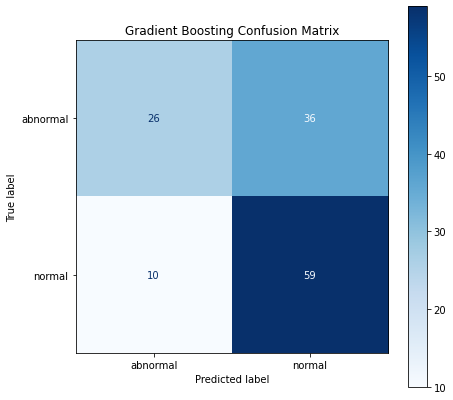

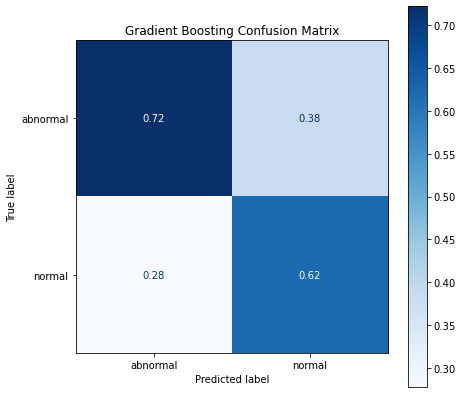

              precision    recall  f1-score   support

           0       0.72      0.42      0.53        62
           1       0.62      0.86      0.72        69

    accuracy                           0.65       131
   macro avg       0.67      0.64      0.63       131
weighted avg       0.67      0.65      0.63       131



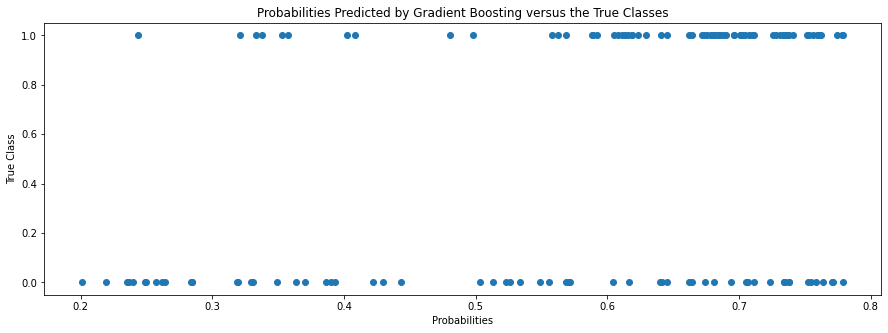

,model,dataset,score
0,Logistic Regression,test,0.702290
1,Logistic Regression,train,0.747541
2,SVM,test,0.687023
3,SVM,train,1.000000
4,KNN,test,0.664122
5,KNN,train,0.685246
6,Decision Tree,test,0.572519
7,Decision Tree,train,0.790164
8,Random Forest,test,0.679389
9,Random Forest,train,0.954098


In [54]:
param_grid = {'min_child_weight': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'subsample': [i/10 for i in range(2, 11, 2)],
              'n_estimators': [i*10 for i in range(1,10, 5)]}
my_estimator = XGBClassifier(learning_rate=0.1, random_state=1)

run_model(my_estimator, 
          param_grid, 
          X_train_mel, 
          y_train, 
          X_test_mel, 
          y_test, 
          total_run_times_dataframe, 
          "Gradient Boosting")

total_run_times_dataframe

## Repeat the process for different splits

In [93]:
def run_model(estimator, param_grid, X_train_mel, y_train, X_test_mel, y_test, total_run_times_dataframe, model_name, verbose=0):
    
    if (verbose):
        print("Fitting model")
    my_gs = GridSearchCV(estimator, param_grid, cv=CV_FOLD, verbose=1, n_jobs=3)
    my_gs.fit(X_train_mel, y_train);
    
    train_acc = my_gs.score(X_train_mel, y_train)
    test_acc = my_gs.score(X_test_mel, y_test)
    
    if (verbose):
        print(f"The training accuracy is {round(train_acc*100,2)}%")
        print(f"The test accuracy is {round(test_acc*100,2)}%")
    
    print(f"Optimal Parameters are: {my_gs.best_params_}")

    if (verbose):
    
        figure, ax = plt.subplots(figsize=(7, 7))
        disp = plot_confusion_matrix(my_gs, X_test_mel, y_test,
                                     display_labels = condition_label_encoder.classes_,
                                     cmap=plt.cm.Blues,
                                     normalize=None,
                                     ax=ax)
        disp.ax_.set_title(f"{model_name} Confusion Matrix")
        plt.show()

        figure, ax = plt.subplots(figsize=(7, 7))
        disp = plot_confusion_matrix(my_gs, X_test_mel, y_test,
                                 display_labels=condition_label_encoder.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='pred',
                                 ax=ax)
        disp.ax_.set_title(f"{model_name} Confusion Matrix")
        plt.show()

        print(classification_report(y_test, my_gs.predict(X_test_mel)))

        y_proba = my_gs.predict_proba(X_test_mel)

        plt.figure(figsize=(15, 5))    
        plt.scatter(y_proba[:, 1], y_test)
        plt.xlabel("Probabilities")
        plt.ylabel("True Class")
        plt.title(f"Probabilities Predicted by {model_name} versus the True Classes")
        plt.show();
    
    
    current_row = total_run_times_dataframe.shape[0]
    total_run_times_dataframe.loc[current_row, 'model'] = model_name
    total_run_times_dataframe.loc[current_row, 'dataset'] = "test"
    total_run_times_dataframe.loc[current_row, 'score'] = test_acc

    current_row = total_run_times_dataframe.shape[0]
    total_run_times_dataframe.loc[current_row, 'model'] = model_name
    total_run_times_dataframe.loc[current_row, 'dataset'] = "train"
    total_run_times_dataframe.loc[current_row, 'score'] = train_acc
    total_run_times_dataframe
    

In [56]:
def preprocess_data(dataset, random_state=None):
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, 
                                                   stratify=dataset['label'], 
                                                   random_state=random_state)

    my_encoder = MelEncoder(n_mels=128, n_windows=1000, verbose=0)
    my_encoder.fit(train_dataset['signal'])

    X_train_mel = my_encoder.transform(train_dataset['signal'])
    X_test_mel = my_encoder.transform(test_dataset['signal'])

    my_mmscaler = MinMaxScaler()

    X_train_mel = my_mmscaler.fit_transform(X_train_mel)
    X_test_mel = my_mmscaler.transform(X_test_mel)

    component_number = min(*X_train_mel.shape)
    my_pca = PCA(n_components=component_number, svd_solver='auto')
    my_pca.fit(X_train_mel)

    X_train_mel = my_pca.transform(X_train_mel)
    X_test_mel = my_pca.transform(X_test_mel)

    condition_label_encoder = LabelEncoder()


    y_train = condition_label_encoder.fit_transform(train_dataset['label'])[:X_train_mel.shape[0]]
    y_test = condition_label_encoder.transform(test_dataset['label'])
    
    return X_train_mel, X_test_mel, y_train, y_test

In [57]:
#total_run_times_dataframe = pd.DataFrame({"model": [],
#                                          "dataset": [],
#                                          "score": []})

In [112]:
%%time
CV_FOLD = 5



logit = LogisticRegression(solver='saga')
logit_params = param_grid = {'penalty': ['l1', 'l2'],
              'C': [2**i for i in range(-17, 18)]}
logit_name = "Logistic Regression"

logit_tuple = (logit, logit_params, logit_name)


svm_model = SVC(max_iter=1000, probability=True, random_state=1)
svm_params = {'C': [10**i for i in range(-7, 8)],
              'kernel': ['poly', 'rbf', 'sigmoid', 'linear']}
svm_name = "SVM"
svm_tuple = (svm_model, svm_params, svm_name)


knn = KNN()
knn_params = {'n_neighbors': [i for i in range(3,10)] + \
                             [i for i in range(10, 100, 5)] + \
                             [i for i in range(100, X_train_mel.shape[0]//2, 20)],
              'weights': ['uniform', 'distance']}
knn_name = "KNN"
knn_tuple = (knn, knn_params, knn_name)


dt = DecisionTreeClassifier(random_state=1)
dt_params = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)]}
dt_name = "Decision Tree"
dt_tuple = (dt, dt_params, dt_name)


rf = RandomForestClassifier(random_state=1)
rf_params = {'min_samples_leaf': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'max_features': [i/10 for i in range(2, 11, 2)],
              'n_estimators': [i*10 for i in range(1,10, 5)]}
rf_name = "Random Forest"
rf_tuple = (rf, rf_params, rf_name)

xgb = XGBClassifier(learning_rate=0.1, random_state=1)
xgb_params = {'min_child_weight': [i for i in range(1, 20)],
              'max_depth' : [i for i in range(1, X_train_mel.shape[1], X_train_mel.shape[1]//10)]+[None],
              'subsample': [i/10 for i in range(2, 11, 2)],
              'n_estimators': [i*10 for i in range(1,10, 5)]}
xgb_name = "Gradient Boosting"
xgb_tuple = (xgb, xgb_params, xgb_name)




model_list = [logit_tuple, svm_tuple, knn_tuple, dt_tuple]
model_list = [logit_tuple, svm_tuple, knn_tuple, dt_tuple, rf_tuple, xgb_tuple]
for i in range(3):
    print("Sleeping")
    time.sleep(60*10) # Sleep for 10 minutes between runs
    print(f"{i}: Preprocessing data...")
    X_train_mel, X_test_mel, y_train, y_test = preprocess_data(dataset, random_state=None)
    for estimator, param_grid, model_name in model_list:
        print(f"Running {model_name}")

        run_model(estimator, 
                  param_grid, 
                  X_train_mel, 
                  y_train, 
                  X_test_mel, 
                  y_test, 
                  total_run_times_dataframe, 
                  model_name)



    total_run_times_dataframe.to_csv('outputs/scores.csv', index=False)
total_run_times_dataframe

Sleeping
0: Preprocessing data...
processed: 99.67%
processed: 99.24%
Running Logistic Regression
Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 145 tasks      | elapsed:    3.9s
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:   11.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Optimal Parameters are: {'C': 0.000244140625, 'penalty': 'l2'}
Running SVM
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    9.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Optimal Parameters are: {'C': 1, 'kernel': 'rbf'}
Running KNN
Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=3)]: Done 245 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 280 out of 280 | elapsed:    1.0s finished


Optimal Parameters are: {'n_neighbors': 8, 'weights': 'uniform'}
Running Decision Tree
Fitting 5 folds for each of 1140 candidates, totalling 5700 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 890 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 3522 tasks      | elapsed:   16.7s
[Parallel(n_jobs=3)]: Done 5700 out of 5700 | elapsed:   29.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Optimal Parameters are: {'max_depth': 31, 'max_features': 0.2, 'min_samples_leaf': 1}
Running Random Forest
Fitting 5 folds for each of 2280 candidates, totalling 11400 fits


[Parallel(n_jobs=3)]: Done 146 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 746 tasks      | elapsed:   24.0s
[Parallel(n_jobs=3)]: Done 1359 tasks      | elapsed:   58.7s
[Parallel(n_jobs=3)]: Done 1709 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 2329 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 3180 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done 4228 tasks      | elapsed:  5.6min
[Parallel(n_jobs=3)]: Done 5473 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done 6615 tasks      | elapsed:  9.6min
[Parallel(n_jobs=3)]: Done 8116 tasks      | elapsed: 11.8min
[Parallel(n_jobs=3)]: Done 9694 tasks      | elapsed: 14.4min
[Parallel(n_jobs=3)]: Done 11400 out of 11400 | elapsed: 17.3min finished


Optimal Parameters are: {'max_depth': 31, 'max_features': 0.6, 'min_samples_leaf': 11, 'n_estimators': 60}
Running Gradient Boosting
Fitting 5 folds for each of 2280 candidates, totalling 11400 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 119 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done 719 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done 1719 tasks      | elapsed:   31.7s
[Parallel(n_jobs=3)]: Done 3119 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 4919 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 7119 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 9719 tasks      | elapsed:  3.5min
[Parallel(n_jobs=3)]: Done 11400 out of 11400 | elapsed:  4.0min finished


Optimal Parameters are: {'max_depth': 1, 'min_child_weight': 6, 'n_estimators': 10, 'subsample': 0.8}
Sleeping
1: Preprocessing data...
processed: 99.67%
processed: 99.24%
Running Logistic Regression
Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 145 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:   11.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Optimal Parameters are: {'C': 0.0009765625, 'penalty': 'l2'}
Running SVM
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    9.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Optimal Parameters are: {'C': 1, 'kernel': 'rbf'}
Running KNN
Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=3)]: Done 245 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 280 out of 280 | elapsed:    1.0s finished


Optimal Parameters are: {'n_neighbors': 10, 'weights': 'uniform'}
Running Decision Tree
Fitting 5 folds for each of 1140 candidates, totalling 5700 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 890 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 3522 tasks      | elapsed:   16.8s
[Parallel(n_jobs=3)]: Done 5700 out of 5700 | elapsed:   29.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Optimal Parameters are: {'max_depth': 31, 'max_features': 1.0, 'min_samples_leaf': 10}
Running Random Forest
Fitting 5 folds for each of 2280 candidates, totalling 11400 fits


[Parallel(n_jobs=3)]: Done 146 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 746 tasks      | elapsed:   23.7s
[Parallel(n_jobs=3)]: Done 1341 tasks      | elapsed:   56.5s
[Parallel(n_jobs=3)]: Done 1691 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 2293 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 2958 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 3854 tasks      | elapsed:  5.4min
[Parallel(n_jobs=3)]: Done 4829 tasks      | elapsed:  7.0min
[Parallel(n_jobs=3)]: Done 6036 tasks      | elapsed:  8.9min
[Parallel(n_jobs=3)]: Done 7370 tasks      | elapsed: 11.3min
[Parallel(n_jobs=3)]: Done 8666 tasks      | elapsed: 13.8min
[Parallel(n_jobs=3)]: Done 10047 tasks      | elapsed: 16.3min
[Parallel(n_jobs=3)]: Done 11400 out of 11400 | elapsed: 19.2min finished


Optimal Parameters are: {'max_depth': 31, 'max_features': 0.6, 'min_samples_leaf': 2, 'n_estimators': 60}
Running Gradient Boosting
Fitting 5 folds for each of 2280 candidates, totalling 11400 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 187 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done 1387 tasks      | elapsed:   26.9s
[Parallel(n_jobs=3)]: Done 2547 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 3947 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 5747 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 7947 tasks      | elapsed:  3.5min
[Parallel(n_jobs=3)]: Done 10547 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done 11400 out of 11400 | elapsed:  5.1min finished


Optimal Parameters are: {'max_depth': 31, 'min_child_weight': 4, 'n_estimators': 10, 'subsample': 1.0}
Sleeping
2: Preprocessing data...
processed: 99.67%
processed: 99.24%
Running Logistic Regression
Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 145 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done 350 out of 350 | elapsed:   12.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Optimal Parameters are: {'C': 3.0517578125e-05, 'penalty': 'l2'}
Running SVM
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    9.7s finished


Optimal Parameters are: {'C': 1, 'kernel': 'rbf'}
Running KNN
Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 245 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 280 out of 280 | elapsed:    1.1s finished


Optimal Parameters are: {'n_neighbors': 8, 'weights': 'uniform'}
Running Decision Tree
Fitting 5 folds for each of 1140 candidates, totalling 5700 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 890 tasks      | elapsed:    3.7s
[Parallel(n_jobs=3)]: Done 3210 tasks      | elapsed:   17.7s
[Parallel(n_jobs=3)]: Done 5700 out of 5700 | elapsed:   33.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Optimal Parameters are: {'max_depth': 31, 'max_features': 0.6, 'min_samples_leaf': 14}
Running Random Forest
Fitting 5 folds for each of 2280 candidates, totalling 11400 fits


[Parallel(n_jobs=3)]: Done 146 tasks      | elapsed:    3.3s
[Parallel(n_jobs=3)]: Done 746 tasks      | elapsed:   26.0s
[Parallel(n_jobs=3)]: Done 1341 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 1691 tasks      | elapsed:  1.7min
[Parallel(n_jobs=3)]: Done 2263 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 2937 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 3964 tasks      | elapsed:  5.4min
[Parallel(n_jobs=3)]: Done 5209 tasks      | elapsed:  7.4min
[Parallel(n_jobs=3)]: Done 6387 tasks      | elapsed:  9.4min
[Parallel(n_jobs=3)]: Done 7589 tasks      | elapsed: 11.5min
[Parallel(n_jobs=3)]: Done 9158 tasks      | elapsed: 13.9min
[Parallel(n_jobs=3)]: Done 10566 tasks      | elapsed: 16.3min
[Parallel(n_jobs=3)]: Done 11400 out of 11400 | elapsed: 17.8min finished


Optimal Parameters are: {'max_depth': 31, 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 60}
Running Gradient Boosting
Fitting 5 folds for each of 2280 candidates, totalling 11400 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 187 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 1387 tasks      | elapsed:   23.9s
[Parallel(n_jobs=3)]: Done 3387 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 6187 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 9787 tasks      | elapsed:  3.7min
[Parallel(n_jobs=3)]: Done 11400 out of 11400 | elapsed:  4.3min finished


Optimal Parameters are: {'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 60, 'subsample': 1.0}
Sleeping


KeyboardInterrupt: 

In [117]:
grouped_df = total_run_times_dataframe.groupby(['model', 'dataset']).agg(['mean', 'std']).reset_index()


train_grouped_df = grouped_df[grouped_df['dataset'] == 'train']
display(train_grouped_df)

test_grouped_df = grouped_df[grouped_df['dataset'] == 'test']
display(test_grouped_df)

model dataset     score          
                                     mean       std
1         Decision Tree   train  0.862568  0.073533
3     Gradient Boosting   train  0.873770  0.103100
5                   KNN   train  0.798907  0.124287
7   Logistic Regression   train  0.763388  0.051686
9         Random Forest   train  0.988251  0.018091
11                  SVM   train  0.808197  0.087826

model dataset     score          
                                     mean       std
0         Decision Tree    test  0.627863  0.058601
2     Gradient Boosting    test  0.653308  0.046429
4                   KNN    test  0.663486  0.028831
6   Logistic Regression    test  0.681934  0.022629
8         Random Forest    test  0.684478  0.032927
10                  SVM    test  0.708015  0.011792

In [118]:
import plotly.graph_objects as go
models = train_grouped_df['model']

fig = go.Figure(data=[
    go.Bar(name='Train', 
           x=models, 
           y=np.round(100*train_grouped_df['score']['mean'], 2), 
           error_y={"array":np.round(100*train_grouped_df['score']['std'], 2)}),
    go.Bar(name='Test', 
           x=models, 
           y=round(100*test_grouped_df['score']['mean'], 2), 
           error_y={"array":np.round(100*test_grouped_df['score']['std'],2)})
])
# Change the bar mode
fig.update_layout(barmode='group', title_text='Accuracy Comparison across Different Models')
fig.show()

In [119]:
ungrouped_test_df = total_run_times_dataframe[total_run_times_dataframe['dataset'] == 'test']
ungrouped_test_df.head()

,model,dataset,score
0,Logistic Regression,test,0.702290
2,SVM,test,0.725191
4,KNN,test,0.725191
6,Decision Tree,test,0.595420
8,Random Forest,test,0.702290


In [120]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

result = pairwise_tukeyhsd(ungrouped_test_df['score'], ungrouped_test_df['model'])
result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Decision Tree,Gradient Boosting,0.0254,0.5372,-0.0187,0.0696,False
Decision Tree,KNN,0.0356,0.183,-0.0086,0.0798,False
Decision Tree,Logistic Regression,0.0541,0.0079,0.0099,0.0982,True
Decision Tree,Random Forest,0.0566,0.0047,0.0124,0.1008,True
Decision Tree,SVM,0.0802,0.001,0.036,0.1243,True
Gradient Boosting,KNN,0.0102,0.9,-0.034,0.0544,False
Gradient Boosting,Logistic Regression,0.0286,0.4121,-0.0156,0.0728,False
Gradient Boosting,Random Forest,0.0312,0.3151,-0.013,0.0753,False
Gradient Boosting,SVM,0.0547,0.0069,0.0105,0.0989,True
KNN,Logistic Regression,0.0184,0.8002,-0.0257,0.0626,False


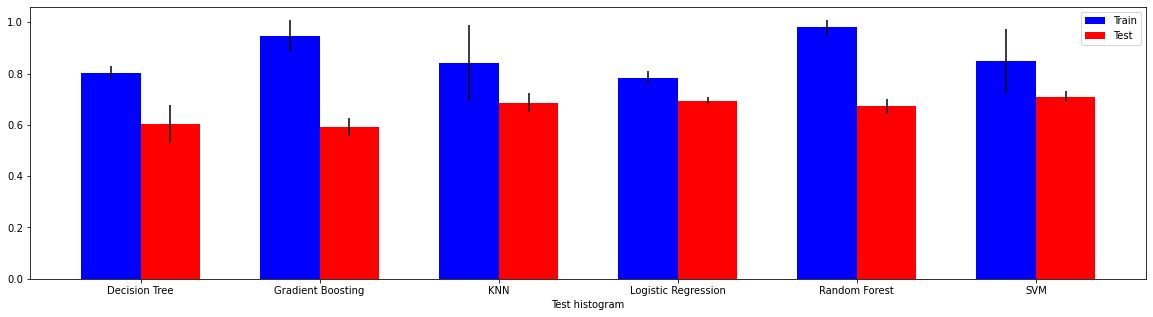

In [60]:
# https://stackoverflow.com/questions/10369681/how-to-plot-bar-graphs-with-same-x-coordinates-side-by-side-dodged
import numpy as np
import matplotlib.pyplot as plt

# The data
train_means = train_grouped_df['score']['mean']
test_means = test_grouped_df['score']['mean']

train_err = train_grouped_df['score']['std']
test_err = test_grouped_df['score']['std']

indices = range(len(train_means))
names = train_grouped_df['model'].values
# Calculate optimal width
width = np.min(np.diff(indices))/3.

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.bar(indices-width/2.,
       train_means,
       width,
       color='b',
       label='Train',
       yerr=train_err)

ax.bar(indices+width/2.,
       test_means,
       width,
       color='r',
       label='Test',
       yerr=test_err)
#tiks = ax.get_xticks().tolist()
#ax.axes.set_xticklabels(names)
plt.xticks(indices, names)
ax.set_xlabel('Test histogram')
plt.legend()
plt.show()